## Stock price prediction using LSTM

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

ModuleNotFoundError: No module named 'google.colab'

In [3]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers, metrics, losses, optimizers
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas
from sklearn.preprocessing import MinMaxScaler

In [4]:
# 주식 데이터셋: Open, High, Low, Volume, Close ...
xy = np.loadtxt('./stock.csv', delimiter=',')
pandas.DataFrame(xy)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,18950.0,19750.0,18650.0,19580.0,19230.0,18920.0,19972.50,7342660.0,10192944.0,8266686.0,...,31.81,-36.59,145.78,-5.37,-151.16,100.61,102.44,104.12,98.64,19700.0
1,19300.0,19450.0,18200.0,19300.0,19250.0,18847.5,19935.00,21564141.0,12884367.0,9866684.0,...,27.58,-68.29,63.16,-72.21,-135.37,95.34,95.58,97.63,92.30,18400.0
2,18750.0,18950.0,18400.0,19060.0,19225.0,18817.5,19902.50,10909042.0,13979186.0,10335555.0,...,23.92,-69.01,31.63,-95.84,-127.46,98.37,97.53,99.64,94.21,18750.0
3,18800.0,19400.0,18750.0,18990.0,19315.0,18840.0,19875.83,8704459.0,11651687.0,10777808.0,...,22.76,-54.93,43.28,-73.37,-116.64,101.37,99.66,102.18,96.85,19250.0
4,18900.0,19400.0,18900.0,19050.0,19325.0,18860.0,19847.50,7062182.0,11116497.0,10799980.0,...,21.75,-61.19,42.99,-62.90,-105.89,100.52,99.09,101.54,96.49,19150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,82500.0,84800.0,82400.0,86980.0,86470.0,89155.0,86106.67,5518522.0,3993373.0,3798362.0,...,32.45,-80.77,-604.85,-662.30,-57.45,96.92,97.49,94.55,97.90,84300.0
2126,85700.0,86400.0,85200.0,86460.0,86150.0,88690.0,86188.33,3798356.0,3916402.0,3990597.0,...,31.69,-72.12,-567.17,-766.42,-199.25,98.54,98.90,96.06,98.85,85200.0
2127,83000.0,84000.0,82500.0,85460.0,85870.0,88125.0,86241.67,3838303.0,4029140.0,3909732.0,...,33.18,-86.21,-620.50,-974.87,-354.37,97.71,97.24,94.75,96.82,83500.0
2128,83500.0,85700.0,83400.0,84700.0,85740.0,87660.0,86315.00,3003603.0,4115865.0,3915592.0,...,31.85,-56.96,-477.76,-951.57,-473.81,101.18,99.95,97.76,99.29,85700.0


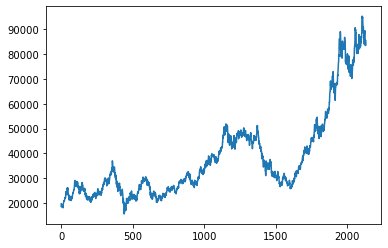

In [5]:
plt.plot(xy[:,-1])

In [ ]:
seq_length = 7  # 한번에 불러올 길이
data_dim = 26   # feature
hidden_dim = 32 
output_dim = 1
learning_rate = 0.01
epochs = 500

# train/test split
x = xy[:,:-1]
y = xy[:,-1].reshape(-1,1)
# 스케일링
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
x_scaler.fit(x)
y_scaler.fit(y)
x = x_scaler.transform(x)
y = y_scaler.transform(y)
xy = np.concatenate((x,y),axis = 1)

# 데이터셋을 70:30으로 나누기
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence


# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

model = tf.keras.Sequential()
model.add(layers.InputLayer((seq_length, data_dim)))
model.add(layers.LSTM(hidden_dim))
model.add(layers.Dense(output_dim))

train_loss = metrics.Mean(name='train_loss')

test_loss = metrics.Mean(name='test_loss')

loss_object = losses.MeanSquaredError()

optimizer = optimizers.Adam(learning_rate)

model.compile(optimizer=optimizer, loss=loss_object)

model.summary()

history = model.fit(x=trainX, y=trainY, epochs=epochs)

print(history)

In [ ]:
predictY = model(testX)
rmse_val = loss_object(testY, predictY)
print("scaling RMSE: {}".format(rmse_val))

testY = y_scaler.inverse_transform(testY)
predictY = y_scaler.inverse_transform(predictY)
rmse_val = loss_object(testY, predictY)
print("origin RMSE: {}".format(rmse_val))


In [ ]:
plt.plot(testY, label='target')
plt.plot(predictY, label='prediction')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.legend()
plt.show()